# Automatic segmentation of Focal Cortical Dysplasia lesions using deep convolutional neural networks. 


In [ ]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 150

In [ ]:
!nvidia-smi

Thu Nov 12 13:45:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   45C    P0    58W / 300W |      0MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# !pip install --quiet --upgrade pip
# !pip install --quiet --upgrade niwidgets
# !pip install --quiet --upgrade highresnet
# !pip install --quiet --upgrade unet
# !pip install --quiet --upgrade torchio
# !pip install tqdm -U
#!apt-get -qq install tree

## **Import dependencies**

In [ ]:
import copy
import enum
import random; random.seed(seed)
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
torch.manual_seed(seed)

import torchio as tio
from torchio import AFFINE, DATA

import numpy as np
import nibabel as nib
from unet import UNet
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

print('TorchIO version:', tio.__version__)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

TorchIO version: 0.17.51


## *Defining helper functions for loading and displaying images*

In [ ]:
def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_subject(subject, image_name, label_name=None):
    if label_name is not None:
        subject = copy.deepcopy(subject)
        affine = subject[label_name].affine
        label_image = subject[label_name].as_sitk()
        label_image = sitk.Cast(label_image, sitk.sitkUInt8)
        border = sitk.BinaryContour(label_image)
        border_array, _ = tio.utils.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)[0]
        image_tensor = subject[image_name].data[0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        subject[image_name].save(f.name)
        show_nifti(f.name)

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

In [ ]:
!pwd

/workspace/sharad/Final


In [ ]:
directory = Path('/workspace/sharad/Final/Fcd_Data')
images_dir = directory / 'images'
inter_dir = directory / 'Interhemi'
pvms_dir = directory / 'Pvms'
labels_dir = directory / 'Labels_new'

images_paths = sorted(images_dir.glob('*nii.gz'))
inter_paths = sorted(inter_dir.glob('*nii.gz'))
pvms_paths = sorted(pvms_dir.glob('*nii.gz'))
labels_paths = sorted(labels_dir.glob('*nii.gz'))

subjects = []

for (images_path,inter_path,pvms_path,labels_path) in zip(images_paths,inter_paths,pvms_paths,labels_paths):
  
  subject = tio.Subject(
        mri=tio.ScalarImage(images_path),
        inter=tio.ScalarImage(inter_path),
        pvm=tio.ScalarImage(pvms_path),
        label=tio.LabelMap(labels_path),
    )
  subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 20 subjects


## Sanity check: Display image and label for one subject 

In [ ]:
one_subject = dataset[2]
print(one_subject)
print(one_subject.mri)
show_subject(tio.ToCanonical()(one_subject), 'mri', label_name='label')

Subject(Keys: ('mri', 'inter', 'pvm', 'label'); images: 4)
ScalarImage(shape: (1, 256, 256, 192); spacing: (0.92, 0.92, 0.94); orientation: RAS+; memory: 48.0 MiB; type: intensity)


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=127, continuous_update=False, description='x', max=255), IntSlider(value…

In [ ]:
num_subjects = len(dataset)
num_training_subjects = 16

training_subjects = subjects[:num_training_subjects]
validation_subjects = subjects[num_training_subjects:-2]
testing_subjects = subjects[num_training_subjects+2:]

training_set = tio.SubjectsDataset(
    training_subjects)

validation_set = tio.SubjectsDataset(
    validation_subjects)

testing_set = tio.SubjectsDataset(testing_subjects)

print('Training set:', len(training_set), 'subjects')

print('Validation set:', len(validation_set), 'subjects')

print('Testing set:', len(testing_set), 'subjects')

Training set: 16 subjects
Validation set: 2 subjects
Testing set: 2 subjects


## Defining more functions that perform the following:

1. Define functions for computing loss and defining hyperparameters.
2. Load the MR images by batch and concatenate all modalities.
3. Define function to run 1 epoch using 1 batch of images during training.
4. Define Training sequence.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    imgs = batch['mri'][DATA]
    intermaps = batch['inter'][DATA]
    pvmmaps = batch['pvm'][DATA]
    inputs = torch.cat([imgs,intermaps,pvmmaps],dim = 1).to(device)
    foreground = batch['label'][DATA].to(device)
    background = 1 - foreground
    targets = foreground
    #targets = torch.cat((background, foreground), dim=CHANNELS_DIMENSION)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=3,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=6,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            dice = get_dice_score(probabilities, targets)
            dice_v = dice.mean()
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f} dice value: {dice_v.mean():0.3f}')

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    #run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch ', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')

## Define TorchIO image loading queue

For more information about using Queues refer [this documentation](https://torchio.readthedocs.io/data/patch_training.html#queue)

In [ ]:
Ttraining_batch_size = 100
validation_batch_size = 2 * training_batch_size

patch_size = 32
samples_per_volume = 40
max_queue_length = 800

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.sampler.LabelSampler(patch_size, 'label', {0:1,1:1}),
    num_workers=0,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.sampler.LabelSampler(patch_size, 'label',{0:1,1:1}),
    num_workers=0,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

## Visualizing patches created for one batch

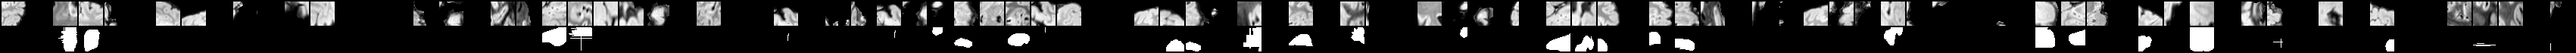

In [ ]:
one_batch = next(iter(training_loader))
k = int(patch_size // 8)
batch_mri = one_batch['mri'][DATA][..., k]
batch_label = one_batch['label'][DATA][..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
save_image(slices, image_path, nrow=training_batch_size, normalize=True, scale_each=True)
display.Image(image_path)

## Start the training sequence

In [ ]:
model, optimizer = get_model_and_optimizer(device)

weights_stem = 'patches'
train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)

## Inference
 1. Run inference sequence on the test set (performed by batch)
 2. Aggregate the output patches to reconstruct the full image (Reference is the T1/T2-FLAIR volume space)
 3. Convert to Nifti format and save the file

In [ ]:
sample = testing_set[0]
input_tensor = torch.zeros_like(sample.mri.data[0])
patch_size = 32  # we can user larger patches for inference
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        imgs = patches_batch['mri'][DATA]
        intermaps = patches_batch['inter'][DATA]
        pvmmaps = patches_batch['pvm'][DATA]
        inputs = torch.cat([imgs,intermaps,pvmmaps],dim = 1).to(device)
        locations = patches_batch[tio.LOCATION]
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)

foreground = aggregator.get_output_tensor()
affine = sample.mri.affine

label_image = tio.utils.nib_to_sitk(foreground, affine)

border_array, _ = tio.utils.sitk_to_nib(label_image)
input_tensor[border_array > 0.5] = 1
nii = nib.Nifti1Image(input_tensor.numpy(), affine)
show_nifti(nii)
#nib.save(nii, 'out2.nii.gz')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torchio/data/inference/aggregator.py:159: UserWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message)


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=84, continuous_update=False, description='x', max=169), IntSlider(value=…

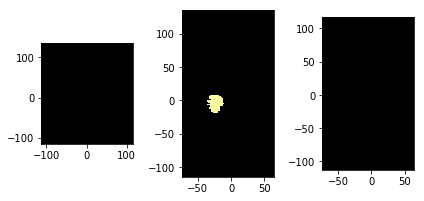

In [ ]:
sample.label.plot()